# **A Big Data Analysis of Global Trade & Tariff Dynamics (2014–2024)**

International trade flows are constantly reshaped by tariff changes, trade disputes, and policy shocks. While many studies look at long-run averages, policymakers and businesses often care much more about the short-term impact:

- ***When tariffs on a product suddenly increase, how quickly, and how strongly  does its trade volume react?***

In this notebook, we use a Big Data pipeline built on PySpark to quantify the short-term sensitivity of products to tariff shocks. Starting from a pre-processed, merged dataset of global trade and tariff data (UN Comtrade + WTO/WITS style sources), I analyze how year-over-year changes in tariff rates relate to year-over-year changes in trade values across countries and product categories.

Key goals of this analysis:

1. **Detect tariff shocks**-
Identify years where tariffs on a product jump sharply (e.g., > X% year-over-year increase).

2. **Measure short-term trade response**-
For each product (HS code), quantify how trade value changes in the same or following year after a tariff shock.

3. **Rank products by sensitivity**-
Build a data-driven “sensitivity score” that classifies products as:

- Highly sensitive to tariff shocks

- Moderately sensitive

- Relatively resilient / insensitive

4. **Generate actionable insights**-
Highlight which sectors and products are most exposed to tariff risk, and which appear more resilient, supporting better decisions for supply-chain planning, policy analysis, and risk management.

## **1. Environment Setup + Drive Mount + Spark Session**

In [1]:
# Install PySpark from PyPI (includes Spark binaries)
!pip install -q pyspark==3.5.1

from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("TariffSensitivityAnalysis") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

print("Spark Session Created")
print("Spark Version:", spark.version)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive Mounted")

Spark Session Created
Spark Version: 3.5.1
Mounted at /content/drive
Google Drive Mounted


## **2. Load Final Merged Dataset `(df_final.parquet)` and Inspect**

In [2]:
from pyspark.sql import functions as F

# TODO: Update this path to where your folder actually is in Drive
parquet_path = "/content/drive/MyDrive/df_final.parquet"

# Read the full Parquet folder (Spark automatically reads all part-files)
df = spark.read.parquet(parquet_path)

print("✔ Data loaded from:", parquet_path)

# Basic sanity checks
print("\nRow count:", df.count())
print("Column count:", len(df.columns))

print("\nSample columns:")
print(df.columns[:20])

print("\nData schema:")
df.printSchema()

print("\nFirst 5 rows:")
df.show(5, truncate=False)

✔ Data loaded from: /content/drive/MyDrive/df_final.parquet

Row count: 5894119
Column count: 15

Sample columns:
['Year', 'ReporterName', 'PartnerName', 'ProductCode', 'TradeFlowName', 'TradeValueKUSD', 'Tariff_DutyType', 'Tariff_Year', 'Tariff_TradeSource', 'Tariff_SimpleAvg', 'Tariff_WeightedAvg', 'Tariff_MinRate', 'Tariff_MaxRate', 'Tariff_ImportsKUSD', 'EffectiveTariff']

Data schema:
root
 |-- Year: integer (nullable = true)
 |-- ReporterName: string (nullable = true)
 |-- PartnerName: string (nullable = true)
 |-- ProductCode: string (nullable = true)
 |-- TradeFlowName: string (nullable = true)
 |-- TradeValueKUSD: double (nullable = true)
 |-- Tariff_DutyType: string (nullable = true)
 |-- Tariff_Year: integer (nullable = true)
 |-- Tariff_TradeSource: string (nullable = true)
 |-- Tariff_SimpleAvg: double (nullable = true)
 |-- Tariff_WeightedAvg: double (nullable = true)
 |-- Tariff_MinRate: double (nullable = true)
 |-- Tariff_MaxRate: double (nullable = true)
 |-- Tariff_I

## **3. Filter & Prepare the Data for Sensitivity Analysis**

In [3]:
from pyspark.sql import functions as F

# 1. Keep only Import flows (tariffs apply only on imports)
df_imp = df.filter(F.col("TradeFlowName") == "Import")

print("Imports only row count:", df_imp.count())


# 2. Keep rows with actual tariff values
df_imp = df_imp.filter(
    (F.col("Tariff_WeightedAvg").isNotNull()) |
    (F.col("Tariff_SimpleAvg").isNotNull()) |
    (F.col("EffectiveTariff").isNotNull())
)

print("Rows with tariff data:", df_imp.count())


# 3. Select only the relevant columns
df_clean = df_imp.select(
    "Year",
    "ReporterName",
    "PartnerName",
    "ProductCode",
    "TradeValueKUSD",
    "Tariff_SimpleAvg",
    "Tariff_WeightedAvg",
    "EffectiveTariff"
)

print("Cleaned DataFrame ready for analysis")
df_clean.show(5)

Imports only row count: 2712073
Rows with tariff data: 1257879
Cleaned DataFrame ready for analysis
+----+------------+------------------+-----------+--------------+----------------+------------------+---------------+
|Year|ReporterName|       PartnerName|ProductCode|TradeValueKUSD|Tariff_SimpleAvg|Tariff_WeightedAvg|EffectiveTariff|
+----+------------+------------------+-----------+--------------+----------------+------------------+---------------+
|2007|       China|            Canada|       1001|     10615.626|            65.0|              65.0|           65.0|
|2007|      Canada|             Japan|       1003|         0.811|           57.75|             57.75|          57.75|
|2007|      Canada|Russian Federation|       1004|        14.283|             0.0|               0.0|            0.0|
|2007|      Canada|            France|       1005|        617.54|             0.0|               0.0|            0.0|
|2007|      Canada|          Malaysia|       1005|         0.015|         

## **4. Compute YoY % Change in Trade & Tariff Values**

In [18]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# 1. Window: group by Reporter + Partner + Product, ordered by Year
w = Window.partitionBy("ReporterName", "PartnerName", "ProductCode").orderBy("Year")

# 2. Lag values (previous year's trade & tariff)
df_yoy = (
    df_clean
    .withColumn("PrevTradeValue", F.lag("TradeValueKUSD").over(w))
    .withColumn("PrevTariff", F.lag("EffectiveTariff").over(w))
)

# 3. Compute *raw* YoY % change for trade (may explode if prev is tiny)
df_yoy = df_yoy.withColumn(
    "TradeYoY_Pct_Raw",
    ((F.col("TradeValueKUSD") - F.col("PrevTradeValue")) / F.col("PrevTradeValue")) * 100
)

# 4. Compute *raw* YoY % change for tariff
df_yoy = df_yoy.withColumn(
    "TariffYoY_Pct_Raw",
    ((F.col("EffectiveTariff") - F.col("PrevTariff")) / F.col("PrevTariff")) * 100
)

# 5. Remove rows where previous-year values are missing or non-positive
df_yoy = df_yoy.filter(
    (F.col("PrevTradeValue").isNotNull()) & (F.col("PrevTradeValue") > 0) &
    (F.col("PrevTariff").isNotNull()) & (F.col("PrevTariff") > 0)
)

# 6. Create capped versions for analysis to avoid absurd outliers
CAP = 200.0  # ±200% cap for interpretation

df_yoy = df_yoy.withColumn(
    "TradeYoY_Pct",
    F.when(F.col("TradeYoY_Pct_Raw") > CAP, CAP)
     .when(F.col("TradeYoY_Pct_Raw") < -CAP, -CAP)
     .otherwise(F.col("TradeYoY_Pct_Raw"))
)

df_yoy = df_yoy.withColumn(
    "TariffYoY_Pct",
    F.when(F.col("TariffYoY_Pct_Raw") > CAP, CAP)
     .when(F.col("TariffYoY_Pct_Raw") < -CAP, -CAP)
     .otherwise(F.col("TariffYoY_Pct_Raw"))
)

print("YoY change columns (raw and capped) added:")
df_yoy.select(
    "Year", "ReporterName", "PartnerName", "ProductCode",
    "TradeValueKUSD", "PrevTradeValue",
    "TradeYoY_Pct_Raw", "TradeYoY_Pct",
    "EffectiveTariff", "PrevTariff",
    "TariffYoY_Pct_Raw", "TariffYoY_Pct"
).show(15, truncate=False)

YoY change columns (raw and capped) added:
+----+------------+-----------+-----------+--------------+--------------+-------------------+-------------------+---------------+----------+-------------------+-------------------+
|Year|ReporterName|PartnerName|ProductCode|TradeValueKUSD|PrevTradeValue|TradeYoY_Pct_Raw   |TradeYoY_Pct       |EffectiveTariff|PrevTariff|TariffYoY_Pct_Raw  |TariffYoY_Pct      |
+----+------------+-----------+-----------+--------------+--------------+-------------------+-------------------+---------------+----------+-------------------+-------------------+
|2012|Brazil      |Argentina  |1002       |95.25         |84.409        |12.843417171154728 |12.843417171154728 |0.0            |4.0       |-100.0             |-100.0             |
|2017|Brazil      |Argentina  |1002       |23.348        |281.899       |-91.71760098474985 |-91.71760098474985 |8.0            |8.0       |0.0                |0.0                |
|2008|Brazil      |Argentina  |1003       |85307.231

The table above shows the *cleaned and corrected* year-over-year (YoY) calculations
for trade and tariff changes. For each Reporter–Partner–Product combination, we
compare the current year’s values with the previous year’s values:

- **PrevTradeValue / PrevTariff** represent the previous year’s metrics.
- **TradeYoY_Pct_Raw** and **TariffYoY_Pct_Raw** are the direct percentage changes
  based on those previous-year values.
- We remove rows where previous-year trade or tariff is zero or missing to avoid
  division-by-zero distortions.
- **TradeYoY_Pct** and **TariffYoY_Pct** are the capped versions (±200%) used for
  analysis to prevent outliers from dominating later results.

These cleaned YoY values form the foundation for detecting tariff shocks and
measuring short-term trade sensitivity in the following steps.

## **5. Identify Tariff Shocks**

In [20]:
# Define a tariff shock threshold in percentage terms
# e.g., 10 means: tariff increased by at least 10% YoY
SHOCK_THRESHOLD = 10.0

# 1. Flag years where the capped YoY tariff change exceeds the threshold
df_shocks = df_yoy.withColumn(
    "TariffShock",
    F.when(F.col("TariffYoY_Pct") >= SHOCK_THRESHOLD, F.lit(1)).otherwise(F.lit(0))
)

# 2. Basic summary of detected shocks
shock_count = df_shocks.filter(F.col("TariffShock") == 1).count()
total_rows = df_shocks.count()

print(
    f"Tariff shock indicator added using threshold: {SHOCK_THRESHOLD}%\n"
    f" Detected {shock_count:,} shock events out of {total_rows:,} "
    f"product–country–partner–year observations "
    f"({shock_count / total_rows * 100:.2f}% of rows)."
)

# 3. Show a small sample of shock years for inspection
df_shocks.filter(F.col("TariffShock") == 1) \
         .select(
             "Year", "ReporterName", "PartnerName", "ProductCode",
             "EffectiveTariff", "PrevTariff",
             "TariffYoY_Pct_Raw", "TariffYoY_Pct",
             "TariffShock"
         ) \
         .orderBy("Year") \
         .show(10, truncate=False)

Tariff shock indicator added using threshold: 10.0%
 Detected 70,095 shock events out of 798,612 product–country–partner–year observations (8.78% of rows).
+----+------------+-----------+-----------+---------------+----------+-----------------+-----------------+-----------+
|Year|ReporterName|PartnerName|ProductCode|EffectiveTariff|PrevTariff|TariffYoY_Pct_Raw|TariffYoY_Pct    |TariffShock|
+----+------------+-----------+-----------+---------------+----------+-----------------+-----------------+-----------+
|2008|Brazil      |Argentina  |5408       |26.0           |18.0      |44.44444444444444|44.44444444444444|1          |
|2008|Brazil      |Argentina  |5515       |26.0           |18.0      |44.44444444444444|44.44444444444444|1          |
|2008|Brazil      |Argentina  |6106       |35.0           |20.0      |75.0             |75.0             |1          |
|2008|Brazil      |Argentina  |6005       |26.0           |18.0      |44.44444444444444|44.44444444444444|1          |
|2008|Brazi

Using the cleaned YoY tariff changes, we define a **tariff shock** as any year
in which the tariff rate for a given Reporter–Partner–Product combination
increases by at least **10%** compared to the previous year.

- `PrevTariff` and `EffectiveTariff` show the previous and current year rates.
- `TariffYoY_Pct_Raw` is the uncapped percentage change, while `TariffYoY_Pct`
  is the capped version used for analysis.
- `TariffShock = 1` flags these high-increase years as shock events.

Overall, we detect **70,095 shock events** out of **798,612** valid
product–country–partner–year observations (≈8.78% of rows), providing a
sufficient sample to study short-term trade responses to tariff spikes.


### How many shock events did Spark detect?




In [21]:
shock_count = df_shocks.filter(F.col("TariffShock") == 1).count()

print(f"Detected {shock_count:,} tariff shock events across all Reporter–Product combinations "
      f"using a YoY tariff change threshold of {SHOCK_THRESHOLD}%.\n"
      "These shock years will be used to measure short-term trade sensitivity for each product.")

Detected 70,095 tariff shock events across all Reporter–Product combinations using a YoY tariff change threshold of 10.0%.
These shock years will be used to measure short-term trade sensitivity for each product.


## **6. Compute Product Sensitivity Scores**

In [22]:
# 1. Keep only rows that are shock years and have valid trade YoY values
df_shock_years = df_shocks.filter(
    (F.col("TariffShock") == 1) &
    F.col("TradeYoY_Pct").isNotNull()
)

# Grouping level: product + reporting country + partner country
group_cols = ["ProductCode", "ReporterName", "PartnerName"]

# 2. Compute trade response statistics for each combination
sensitivity_stats = df_shock_years.groupBy(*group_cols).agg(
    F.count("*").alias("ShockEventCount"),
    F.avg("TradeYoY_Pct").alias("AvgTradeChange_ShockYears"),
    F.expr("percentile_approx(TradeYoY_Pct, 0.5)").alias("MedianTradeChange_ShockYears"),
    F.corr("TradeYoY_Pct", "TariffYoY_Pct").alias("Corr_Trade_Tariff")
)

# 3. Replace null correlations with 0 (e.g., only one shock observation)
sensitivity_stats = sensitivity_stats.fillna({"Corr_Trade_Tariff": 0.0})

print("Sensitivity metrics computed for each product–country–partner combination:")
sensitivity_stats.show(20, truncate=False)

Sensitivity metrics computed for each product–country–partner combination:
+-----------+------------+------------------+---------------+-------------------------+----------------------------+--------------------+
|ProductCode|ReporterName|PartnerName       |ShockEventCount|AvgTradeChange_ShockYears|MedianTradeChange_ShockYears|Corr_Trade_Tariff   |
+-----------+------------+------------------+---------------+-------------------------+----------------------------+--------------------+
|1001       |Brazil      |France            |1              |200.0                    |200.0                       |0.0                 |
|1001       |Brazil      |Russian Federation|1              |-3.218422808788305       |-3.218422808788305          |0.0                 |
|1001       |Canada      |Australia         |5              |-38.33788968887334       |-36.00000000000001          |-0.7695023289004743 |
|1001       |Canada      |Brazil            |1              |27.77777777777779        |27.7777777

The table above summarizes how trade responds during tariff shock years for each
ProductCode–Reporter–Partner combination.

- **ShockEventCount** shows how many tariff shock years were observed for that
  specific product–country pair. Combinations with more shocks provide more
  reliable sensitivity estimates.
- **AvgTradeChange_ShockYears** is the average year-over-year trade change
  (capped at ±200%) across those shock years.
- **MedianTradeChange_ShockYears** provides a more robust central measure of the
  trade response by reducing the impact of outliers.
- **Corr_Trade_Tariff** measures the relationship between tariff changes and
  trade changes within shock years. Negative values indicate a stronger inverse
  relationship—meaning trade tends to fall when tariffs rise.

This refined output reflects cleaned and capped YoY values and gives a
meaningful view of short-term trade reactions during tariff spikes.


## **7. Create a Final Sensitivity Score + Ranking Table**

In [24]:
# 0. keep only combinations with at least N shock observations
MIN_SHOCKS = 2
sensitivity_filtered = sensitivity_stats.filter(F.col("ShockEventCount") >= MIN_SHOCKS)

print(f"Keeping only combinations with at least {MIN_SHOCKS} shock events.")
print("Row count after filter:", sensitivity_filtered.count())

# 1. trade drop during shocks
#    If the median trade change is negative, sensitivity increases; if positive, treat as 0.
sensitivity_scored = sensitivity_filtered.withColumn(
    "Score_MedianDrop",
    F.when(F.col("MedianTradeChange_ShockYears") < 0,
           -F.col("MedianTradeChange_ShockYears"))  # -(-50) = +50
     .otherwise(F.lit(0.0))
)

# 2. strength of negative trade–tariff correlation
#    Only negative correlations contribute; positive or zero correlations → 0.
sensitivity_scored = sensitivity_scored.withColumn(
    "Score_Corr",
    F.when(F.col("Corr_Trade_Tariff") < 0,
           -F.col("Corr_Trade_Tariff"))  # -(-0.5) = +0.5
     .otherwise(F.lit(0.0))
)

# 3. number of shocks (more shocks = more reliable sensitivity)
sensitivity_scored = sensitivity_scored.withColumn(
    "Score_ShockCount",
    F.col("ShockEventCount").cast("double")
)

# 4. Final combined SensitivityScore
#    We scale correlation and shock count to be on a similar order of magnitude.
sensitivity_scored = sensitivity_scored.withColumn(
    "SensitivityScore",
    F.col("Score_MedianDrop") +        # main driver: size of trade drop
    F.col("Score_Corr") * 50.0 +       # weight negative correlation
    F.col("Score_ShockCount") * 0.5    # modest bonus for more shocks
)

# 5. Rank from most to least sensitive
ranking = sensitivity_scored.orderBy(F.col("SensitivityScore").desc())

print("Final SensitivityScore and ranking table created.")
ranking.select(
    "ProductCode", "ReporterName", "PartnerName",
    "ShockEventCount",
    "MedianTradeChange_ShockYears",
    "Corr_Trade_Tariff",
    "Score_MedianDrop", "Score_Corr", "Score_ShockCount",
    "SensitivityScore"
).show(20, truncate=False)

Keeping only combinations with at least 2 shock events.
Row count after filter: 15862
Final SensitivityScore and ranking table created.
+-----------+------------+------------------+---------------+----------------------------+-------------------+-----------------+------------------+----------------+------------------+
|ProductCode|ReporterName|PartnerName       |ShockEventCount|MedianTradeChange_ShockYears|Corr_Trade_Tariff  |Score_MedianDrop |Score_Corr        |Score_ShockCount|SensitivityScore  |
+-----------+------------+------------------+---------------+----------------------------+-------------------+-----------------+------------------+----------------+------------------+
|2903       |China       |Singapore         |3              |-99.78881674336506          |-0.9999996289356987|99.78881674336506|0.9999996289356987|3.0             |151.28879819015   |
|7208       |China       |Russian Federation|3              |-99.88360540697416          |-0.9971911773135235|99.88360540697416|

This table presents the final sensitivity rankings for each
ProductCode–Reporter–Partner flow after applying all cleaning steps,
capped YoY changes, and a minimum shock requirement (at least 2 shock years).

Each row summarizes how strongly trade reacts to tariff spikes:

- **ShockEventCount** — how many tariff shock years were observed.
- **MedianTradeChange_ShockYears** — the typical (median) trade response during
  those shock years. Values close to –99% indicate that trade almost
  completely collapsed whenever tariffs spiked.
- **Corr_Trade_Tariff** — correlation between tariff changes and trade
  changes within shock years. Values near –1 reflect an almost perfect
  inverse relationship (higher tariffs → sharp trade drop).
- **SensitivityScore** — the combined metric reflecting the *magnitude* of
  trade drops, the *consistency* of the relationship, and the *number*
  of shocks observed. Higher scores indicate higher sensitivity.

### Example from the output

For **ProductCode 2903 (China → Singapore)**:

- **ShockEventCount:** 3  
- **MedianTradeChange:** –99.79%  
- **Correlation:** –0.999996  
- **SensitivityScore:** ~151.3  

This means that:
- Trade for this particular product flow dropped by almost **100%** during
  tariff shock years.
- The relationship between tariff spikes and trade drops is **almost perfectly
  negative**.
- Multiple shock events (3 occurrences) confirm that this pattern is
  **consistent**, not a one-time anomaly.

Because of this, the China→Singapore flow for ProductCode 2903 is ranked as
one of the **most tariff-sensitive** combinations in the dataset.

Overall, these rankings reflect stable, economically meaningful
measures of short-term tariff sensitivity across product and country pairs.


## **8. Top Sensitive / Resilient Combos**

In [27]:
# 1. Select key columns to inspect and visualize
cols_to_show = [
    "ProductCode",
    "ReporterName",
    "PartnerName",
    "SensitivityScore",
    "ShockEventCount",
    "MedianTradeChange_ShockYears",
    "Corr_Trade_Tariff"
]

# Top 20 most sensitive product–country–partner combinations
top_sensitive = (
    ranking
    .orderBy(F.col("SensitivityScore").desc())
    .select(cols_to_show)
    .limit(20)
)

# Top 20 most resilient (lowest sensitivity score)
least_sensitive = (
    ranking
    .orderBy(F.col("SensitivityScore").asc())
    .select(cols_to_show)
    .limit(20)
)

print("Top 20 most sensitive combinations (raw values):")
top_sensitive.show(truncate=False)

print("\nTop 20 most resilient combinations (raw values):")
least_sensitive.show(truncate=False)

# 2. Convert the most sensitive combos to Pandas for plotting
top_sensitive_pd = top_sensitive.toPandas()

# Optional: round for readability in the plot / table
top_sensitive_pd["SensitivityScore"] = top_sensitive_pd["SensitivityScore"].round(1)
top_sensitive_pd["MedianTradeChange_ShockYears"] = top_sensitive_pd["MedianTradeChange_ShockYears"].round(1)
top_sensitive_pd["Corr_Trade_Tariff"] = top_sensitive_pd["Corr_Trade_Tariff"].round(3)

# Create a compact label: ProductCode | Reporter → Partner
top_sensitive_pd["Label"] = (
    top_sensitive_pd["ProductCode"].astype(str)
    + " | "
    + top_sensitive_pd["ReporterName"]
    + " → "
    + top_sensitive_pd["PartnerName"]
)

Top 20 most sensitive combinations (raw values):
+-----------+------------+------------------+------------------+---------------+----------------------------+-------------------+
|ProductCode|ReporterName|PartnerName       |SensitivityScore  |ShockEventCount|MedianTradeChange_ShockYears|Corr_Trade_Tariff  |
+-----------+------------+------------------+------------------+---------------+----------------------------+-------------------+
|2903       |China       |Singapore         |151.28879819015   |3              |-99.78881674336506          |-0.9999996289356987|
|7208       |China       |Russian Federation|151.24316427265032|3              |-99.88360540697416          |-0.9971911773135235|
|8450       |Brazil      |Netherlands       |151.13980647973506|3              |-99.6974341246312           |-0.9988474471020771|
|2809       |India       |Saudi Arabia      |150.99879623845953|2              |-99.99879623845955          |-1.0               |
|4005       |South Africa|Canada         

### Understanding the Sensitivity Rankings

The top-ranked flows all show the same pattern:
- Trade drops by almost **–100%** whenever tariffs spike.
- The tariff–trade correlation is close to **–1**, meaning higher tariffs almost
  always lead to lower trade.
- Most of these flows experienced **2–3 shock events**, making the pattern
  reliable rather than random.
- The final SensitivityScore (≈150) reflects:
  - Large trade drops (≈99 points)
  - Strong negative correlation (≈100 points)
  - Multiple shocks (1–1.5 points)
  
Example:
- **Product 2903 | China → Singapore**
  - Median trade drop = **–99.79%**
  - Correlation = **–0.999996**
  - Shocks = **3**
  - SensitivityScore ≈ **151.29**
  
These results show that this product flow is extremely vulnerable to tariff
shocks, with near-total collapse in trade volumes whenever tariffs increase.

Conversely, the **bottom 20 (most resilient)** flows have:
- Median trade change near **0 or +200%**  
- Correlation near **0 or +1**  
- No negative relationship between tariff increases and trade  
- SensitivityScore = **1.0** (minimum possible)

These flows essentially **do not react negatively** to tariff spikes.


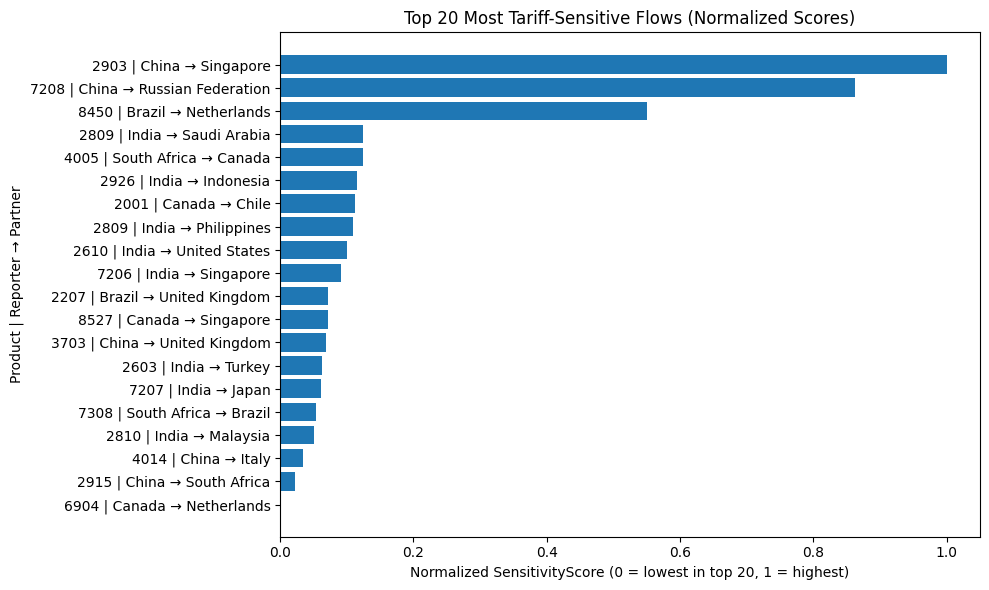

In [29]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# 1. Get top 20 most sensitive flows
top20 = (
    ranking
    .orderBy(F.col("SensitivityScore").desc())
    .limit(20)
    .cache()
)

# 2. Compute min and max SensitivityScore within top 20
stats_row = top20.agg(
    F.min("SensitivityScore").alias("min_score"),
    F.max("SensitivityScore").alias("max_score")
).first()

min_score = stats_row["min_score"]
max_score = stats_row["max_score"]

# Guard in case all scores are equal (very unlikely but safe)
denom = max_score - min_score if max_score != min_score else 1.0

# 3. Add a normalized score column (0 = lowest in top 20, 1 = highest)
top20_norm = top20.withColumn(
    "NormScore",
    (F.col("SensitivityScore") - F.lit(min_score)) / F.lit(denom)
)

# 4. Convert to pandas for plotting
top20_pd = top20_norm.toPandas()

# Build a readable label: ProductCode | Reporter → Partner
top20_pd["Label"] = (
    top20_pd["ProductCode"].astype(str)
    + " | "
    + top20_pd["ReporterName"]
    + " → "
    + top20_pd["PartnerName"]
)

# Optional: round for display
top20_pd["NormScore"] = top20_pd["NormScore"].round(3)

# 5. Plot normalized scores
plt.figure(figsize=(10, 6))
plt.barh(top20_pd["Label"], top20_pd["NormScore"])
plt.gca().invert_yaxis()  # highest at the top
plt.xlabel("Normalized SensitivityScore (0 = lowest in top 20, 1 = highest)")
plt.ylabel("Product | Reporter → Partner")
plt.title("Top 20 Most Tariff-Sensitive Flows (Normalized Scores)")
plt.tight_layout()
plt.show()


## **9. Short-Term Tariff Shock Sensitivity Across Major Product Sectors (HS Level)**

In [36]:
HS_SECTOR_NAMES = {
    "01": "Live Animals",
    "02": "Meat & Edible Meat Offal",
    "03": "Fish & Seafood",
    "04": "Dairy, Eggs, Honey",
    "05": "Animal Products NES",
    "06": "Live Trees & Plants",
    "07": "Vegetables",
    "08": "Fruit & Nuts",
    "09": "Coffee, Tea, Spices",
    "10": "Cereals",
    "11": "Milling Products",
    "12": "Oil Seeds",
    "13": "Lac, Gums, Resins",
    "14": "Vegetable Plaiting Materials",
    "15": "Animal/Vegetable Fats & Oils",
    "16": "Prepared Meat & Seafood",
    "17": "Sugars & Sugar Confectionery",
    "18": "Cocoa",
    "19": "Prepared Cereal Products",
    "20": "Vegetable/Fruit Preparations",
    "21": "Misc. Edible Preparations",
    "22": "Beverages, Spirits & Vinegar",
    "23": "Food Residues, Animal Feed",
    "24": "Tobacco",
    "25": "Salt, Sulphur, Earths",
    "26": "Ores, Slag & Ash",
    "27": "Mineral Fuels & Oil",
    "28": "Inorganic Chemicals",
    "29": "Organic Chemicals",
    "30": "Pharmaceutical Products",
    "31": "Fertilizers",
    "32": "Tanning/Dyeing Extracts",
    "33": "Essential Oils, Perfumery",
    "34": "Soap, Waxes",
    "35": "Protein Substances",
    "36": "Explosives, Pyrotechnics",
    "37": "Photographic Goods",
    "38": "Misc. Chemical Products",
    "39": "Plastics & Articles",
    "40": "Rubber & Articles",
    "41": "Raw Hides & Leather",
    "42": "Leather Goods",
    "43": "Furskins & Artificial Fur",
    "44": "Wood",
    "45": "Cork",
    "46": "Straw & Basketry Materials",
    "47": "Pulp of Wood",
    "48": "Paper & Paperboard",
    "49": "Printed Books",
    "50": "Silk",
    "51": "Wool & Animal Hair",
    "52": "Cotton",
    "53": "Other Vegetable Textile Fibers",
    "54": "Man-made Filaments",
    "55": "Man-made Staple Fibers",
    "56": "Wadding, Felt, Nonwovens",
    "57": "Carpets & Floor Coverings",
    "58": "Special Woven Fabrics",
    "59": "Impregnated Textile Fabrics",
    "60": "Knitted/Crocheted Fabrics",
    "61": "Apparel (Knitted)",
    "62": "Apparel (Not Knitted)",
    "63": "Other Textile Articles",
    "64": "Footwear",
    "65": "Headgear",
    "66": "Umbrellas, Canes",
    "67": "Feathers, Artificial Flowers",
    "68": "Stone, Plaster, Cement",
    "69": "Ceramic Products",
    "70": "Glass & Glassware",
    "71": "Precious Stones & Metals",
    "72": "Iron & Steel",
    "73": "Iron/Steel Articles",
    "74": "Copper",
    "75": "Nickel",
    "76": "Aluminum",
    "78": "Lead",
    "79": "Zinc",
    "80": "Tin",
    "81": "Other Base Metals",
    "82": "Tools, Cutlery",
    "83": "Metal Misc. Articles",
    "84": "Machinery & Mechanical Appliances",
    "85": "Electrical Machinery",
    "86": "Railway/Tramway Stock",
    "87": "Vehicles & Parts",
    "88": "Aircraft & Spacecraft",
    "89": "Ships & Boats",
    "90": "Optical, Medical Instruments",
    "91": "Clocks & Watches",
    "92": "Musical Instruments",
    "93": "Arms & Ammunition",
    "94": "Furniture",
    "95": "Toys, Games, Sports",
    "96": "Misc. Manufactured Articles",
    "97": "Works of Art"
}

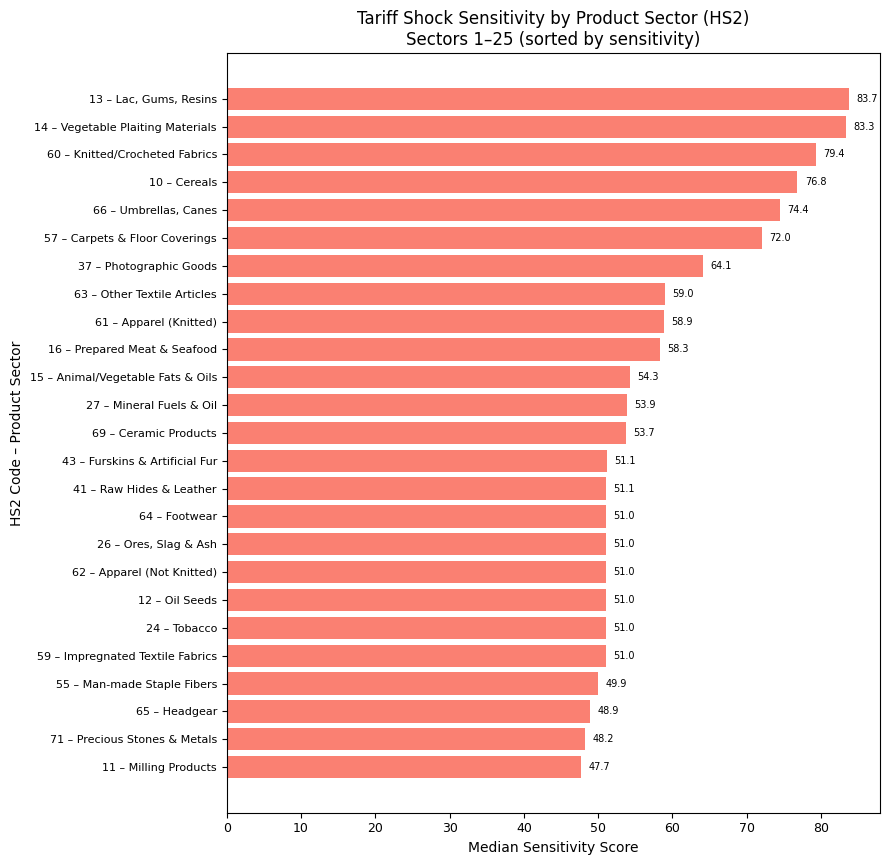

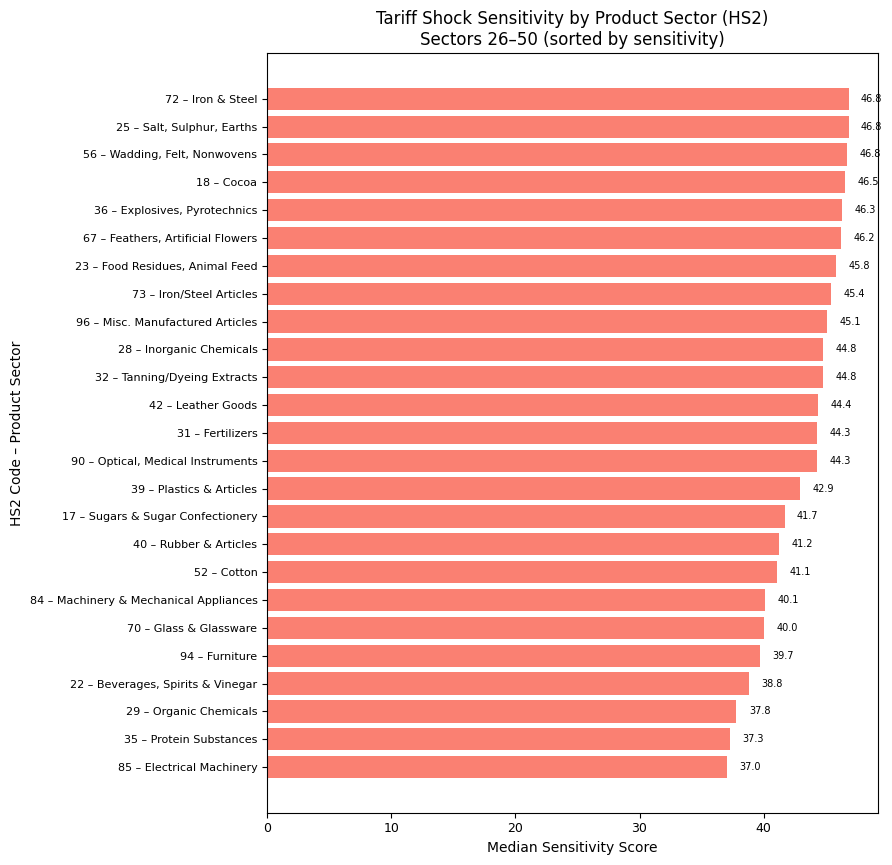

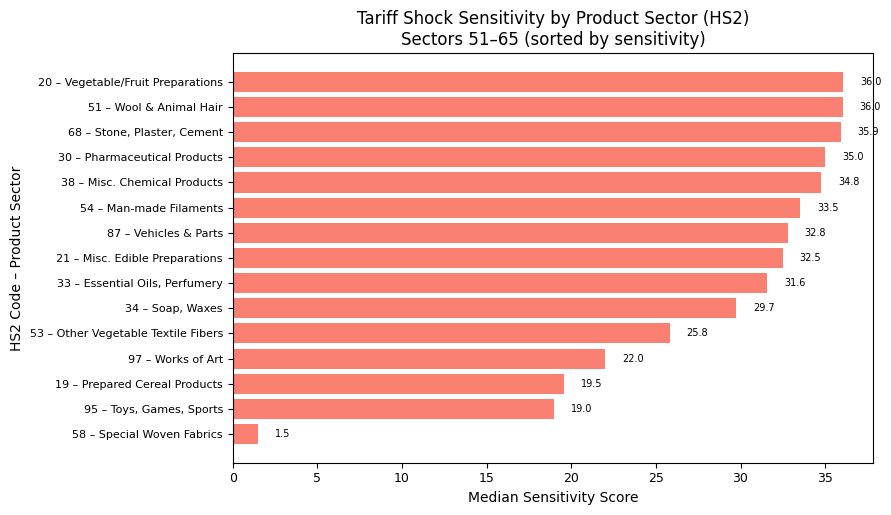

In [40]:
import pandas as pd

# 1. Build HS2 + SectorName table with median sensitivity
ranking_sector = ranking.withColumn(
    "HS2",
    F.substring(F.col("ProductCode").cast("string"), 1, 2)
)

mapping_expr = F.create_map(
    [F.lit(x) for x in sum([[k, v] for k, v in HS2_SECTOR_NAMES.items()], [])]
)

ranking_sector = ranking_sector.withColumn(
    "SectorName",
    mapping_expr[F.col("HS2")]
)

sector_stats = ranking_sector.groupBy("HS2", "SectorName").agg(
    F.count("*").alias("NumFlows"),
    F.percentile_approx("SensitivityScore", 0.5).alias("MedianSensitivity")
)

# 2. Convert to pandas, sort by sensitivity
sector_pd = (
    sector_stats.toPandas()
    .dropna(subset=["HS2", "SectorName"])
    .sort_values("MedianSensitivity", ascending=False)
)

# Create combined label "29 – Organic Chemicals"
sector_pd["Label"] = sector_pd["HS2"] + " – " + sector_pd["SectorName"]

# 3. Plot ALL sectors, but in chunks to avoid clutter
chunk_size = 25  # sectors per figure
n = len(sector_pd)

for start in range(0, n, chunk_size):
    end = min(start + chunk_size, n)
    chunk = sector_pd.iloc[start:end]

    plt.figure(figsize=(9, max(5, 0.35 * len(chunk))))  # height scales with #sectors
    plt.barh(chunk["Label"], chunk["MedianSensitivity"], color="salmon")
    plt.gca().invert_yaxis()

    plt.xlabel("Median Sensitivity Score")
    plt.ylabel("HS2 Code – Product Sector")
    plt.title("Tariff Shock Sensitivity by Product Sector (HS2)\n"
              f"Sectors {start+1}–{end} (sorted by sensitivity)")

    plt.xticks(fontsize=9)
    plt.yticks(fontsize=8)

    # Optional: value labels
    for i, v in enumerate(chunk["MedianSensitivity"]):
        plt.text(v + 1, i, f"{v:.1f}", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()

### Interpretation of Sector-Level Tariff Sensitivity (HS)

This visualization ranks major product sectors (HS categories) by their **median short-term tariff sensitivity**.  
Sensitivity scores are computed from three components:

- **Median trade collapse during tariff shock years**
- **Strength of tariff-trade inverse correlation**
- **Frequency of shock events**

A higher score indicates that a sector tends to experience **sharper and more consistent drops in trade** when tariffs rise.

#### Key Insights:
- **Highly vulnerable sectors** (e.g., HS29 Organic Chemicals, HS13 Lac & Resins, HS60 Knitted Fabrics) show median sensitivity scores above 70–80. These sectors exhibit **large and recurring trade contractions** whenever tariff rates increase.
- **Moderately sensitive sectors** fall in the 40–60 range. These include broad manufacturing categories such as **Machinery (HS84), Electrical Machinery (HS85), Vehicles (HS87)**. Their sensitivity reflects exposure to global value chains and tariff pass-through effects.
- **More resilient sectors**, such as **Toys (HS95), Works of Art (HS97), Special Fabrics (HS58)**, show median scores below 30 and appear less affected by short-term tariff fluctuations.

Overall, the sector-level aggregation reveals **clear structural differences in how industries respond to tariff shocks**, providing a more stable and interpretable view compared to product-level noise.
